# Load of the conectivity matrix

In [4]:
import numpy as np
import iberoSignalPro.preprocesa as ib
import mne
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
import networkx as nx


from ntwktools import *
from statstools import *

In [118]:
Carga_10 = np.load('3Carga_10p01.npy', allow_pickle=True)
Carga_5 = np.load('3Carga_5p01.npy',  allow_pickle=True)
Carga_0 = np.load('3Carga_0p01.npy',  allow_pickle=True)

Carga_5 = Carga_5[:-2]
Carga_0 = Carga_0[:-2]


Carga_10.shape, Carga_5.shape, Carga_0.shape


((41,), (41,), (41,))

In [119]:
ch_names = np.array(['HRV', 'RRV', 'EnvAnta', 'EnvAgo', 'Posicion', 'FC3', 'FCz', 'FC4',
       'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1',
       'Oz', 'O2'], dtype=object)

In [120]:
y, x, ro, deg, _ =ib.eloc_reader('../codigo/eloc16_bueno.txt')


new_x = np.array([x.min() - 0.021,     x.min() - 0.1,    x.max() + 0.1,  x.max() + 0.02, 0])
new_y = np.array([y.max() + 0.25,   y.max() + 0.25,     y.max() + 0.25, y.max() + 0.25, y.max() + 0.25])

x = np.concatenate((new_x, x))
y = np.concatenate((new_y, y))

## Band selection

mu ($\mu$), beta ($\beta$), gamma($\gamma$)

In [121]:
# ************************
# ************************
band = "mu"
test_mat = Carga_10[0].get_network(band, band).matriz_act


# Metrics adquisition

* Input Node Degree: Measures the number of incoming connections to a node, indicating the extent to which a node (or brain region) is influenced by others.
* Output Node Degree: Represents the number of outgoing connections from a node, reflecting how much influence the node exerts on other nodes in the network.
* Betweenness Centrality: Quantifies the importance of a node as a bridge in the shortest paths between other nodes, highlighting its role in facilitating communication within the network.
* Clustering Coefficient: Evaluates the tendency of a node’s neighbors to form connections among themselves, providing insight into the local cohesiveness of the network.

In [122]:
ch_names = np.array(['HRV', 'RRV', 'EnvAnta', 'EnvAgo', 'Posicion', 'FC3', 'FCz', 'FC4',
       'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1',
       'Oz', 'O2'], dtype=object)

In [123]:
def get_ntwk_metrics(Cargas, band = "mu", tipo = "actividad", thresh = 0, only_eeg  = True, ch_names = None, same_windows = True):
    if ch_names is None:
        ch_names = np.array(['FC3', 'FCz', 'FC4', 'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2'], dtype=object)
    in_degree_centrality_all = []
    out_degree_centrality_all = []
    betweenness_centrality_all = []
    max_win = []

    for carga in Cargas:
        if same_windows:
            len_windows_act = carga.get_network(band, band).array_mat_act.shape[0]
            len_windows_rep = carga.get_network(band, band).array_mat_rep.shape[0]
            len_windows = min(len_windows_act, len_windows_rep)


        if tipo == "actividad":
            if same_windows:
                matrices_actividad = carga.get_network(band, band).array_mat_act[:len_windows]
            else:
                matrices_actividad = carga.get_network(band, band).array_mat_act
            
            in_degree_centrality_all_temp = []
            out_degree_centrality_all_temp = []
            betweenness_centrality_all_temp = []

            for test_mat in matrices_actividad:
                if only_eeg:
                    test_mat = test_mat[5:, 5:]

                
                in_degree_centrality, out_degree_centrality = get_deg(test_mat)
                in_degree_centrality_all_temp.append(in_degree_centrality)
                out_degree_centrality_all_temp.append(out_degree_centrality)

                bet = betweenness_centrality(test_mat)

                betweenness_centrality_all_temp.append(bet)

        else:
            if same_windows:
                matrices_reposo = carga.get_network(band, band).array_mat_rep[:len_windows]
            else:
                matrices_reposo = carga.get_network(band, band).array_mat_rep
            
            in_degree_centrality_all_temp = []
            out_degree_centrality_all_temp = []
            betweenness_centrality_all_temp = []
            
            for test_mat in matrices_reposo:
                test_mat = test_mat
                if only_eeg:
                    test_mat = test_mat[5:, 5:]

                
                in_degree_centrality, out_degree_centrality = get_deg(test_mat)
                in_degree_centrality_all_temp.append(in_degree_centrality)
                out_degree_centrality_all_temp.append(out_degree_centrality)
                
                bet = betweenness_centrality(test_mat)
                
                betweenness_centrality_all_temp.append(bet)
                
        
        in_degree_centrality_all_temp = np.array(in_degree_centrality_all_temp)
        out_degree_centrality_all_temp = np.array(out_degree_centrality_all_temp)
        betweenness_centrality_all_temp = np.array(betweenness_centrality_all_temp)
        
        
        in_degree_centrality_all_temp_padded = np.zeros((6, in_degree_centrality_all_temp.shape[1]))
        in_degree_centrality_all_temp_padded[:in_degree_centrality_all_temp.shape[0], :] = in_degree_centrality_all_temp
        
        out_degree_centrality_all_temp_padded = np.zeros((6, out_degree_centrality_all_temp.shape[1]))
        out_degree_centrality_all_temp_padded[:out_degree_centrality_all_temp.shape[0], :] = out_degree_centrality_all_temp
        
        betweenness_centrality_all_temp_padded = np.zeros((6, betweenness_centrality_all_temp.shape[1]))
        betweenness_centrality_all_temp_padded[:betweenness_centrality_all_temp.shape[0], :] = betweenness_centrality_all_temp
        max_win.append(in_degree_centrality_all_temp.shape[0])

        in_degree_centrality_all.append(in_degree_centrality_all_temp_padded)
        out_degree_centrality_all.append(out_degree_centrality_all_temp_padded)
        betweenness_centrality_all.append(betweenness_centrality_all_temp_padded)


    max_win = np.array(max_win)
    in_degree_centrality_all = np.array(in_degree_centrality_all)
    out_degree_centrality_all = np.array(out_degree_centrality_all)
    betweenness_centrality_all = np.array(betweenness_centrality_all)

    return in_degree_centrality_all, out_degree_centrality_all, max_win, betweenness_centrality_all

In [124]:
def promediar_ventanas(arr_act_10in, n_ventanas):
    suma_ventanas = np.sum(arr_act_10in, axis=1)
    promedio_ventanas = suma_ventanas / n_ventanas[:, np.newaxis]
    return promedio_ventanas

def desenvolver_ventanas(arr, n_ventanas, axis = 1):
    # Obtener las dimensiones originales
    num_sujetos, num_ventanas, num_canales = arr.shape
    num_ventanas = np.sum(n_ventanas)
    
    arr_desenvuelto = []
    for i in range(num_sujetos):
        for j in range(n_ventanas[i]):
            arr_desenvuelto.append(arr[i, j, :])
    arr_desenvuelto = np.array(arr_desenvuelto)

    if axis ==2:
    
        arr_desenvuelto = []
        for i in range(num_sujetos):
            for j in range(n_ventanas[i]):
                arr_desenvuelto.append(arr[i, j, :])
        arr_desenvuelto = np.array(arr_desenvuelto)
    
    return arr_desenvuelto

In [125]:
thresh = 0

arr_act_10in, arr_act_10out, act_n_ventanas_10, act_betweenness_centrality_10 = get_ntwk_metrics(Carga_10, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_act_10in = promediar_ventanas(arr_act_10in, act_n_ventanas_10)
arr_act_10out = promediar_ventanas(arr_act_10out, act_n_ventanas_10)
arr_betweenness_centrality_10 =promediar_ventanas(act_betweenness_centrality_10, act_n_ventanas_10)

arr_rep_10in, arr_rep_10out, rep_n_ventanas_10, rep_betweenness_centrality_10 = get_ntwk_metrics(Carga_10, band = band, tipo = "reposo",  thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_rep_10in = promediar_ventanas(arr_rep_10in, rep_n_ventanas_10)
arr_rep_10out = promediar_ventanas(arr_rep_10out, rep_n_ventanas_10)


arr_act_5in, arr_act_5out, act_n_ventanas_5, act_betweenness_centrality_5 = get_ntwk_metrics(Carga_5, band = band, tipo = "actividad",  thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_act_5in = promediar_ventanas(arr_act_5in, act_n_ventanas_5)
arr_act_5out = promediar_ventanas(arr_act_5out, act_n_ventanas_5)


arr_rep_5in, arr_rep_5out, rep_n_ventanas_5, rep_betweenness_centrality_5= get_ntwk_metrics(Carga_5, band =band, tipo = "reposo",  thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_rep_5in = promediar_ventanas(arr_rep_5in, rep_n_ventanas_5)
arr_rep_5out = promediar_ventanas(arr_rep_5out, rep_n_ventanas_5)

arr_act_0in, arr_act_0out, act_n_ventanas_0, act_betweenness_centrality_0 = get_ntwk_metrics(Carga_0, band =band, tipo = "actividad",  thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_act_0in = promediar_ventanas(arr_act_0in, act_n_ventanas_0)
arr_act_0out = promediar_ventanas(arr_act_0out, act_n_ventanas_0)

arr_rep_0in, arr_rep_0out, rep_n_ventanas_0, rep_betweenness_centrality_0 = get_ntwk_metrics(Carga_0, band =band, tipo = "reposo",  thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
arr_rep_0in = promediar_ventanas(arr_rep_0in, rep_n_ventanas_0)
arr_rep_0out = promediar_ventanas(arr_rep_0out, rep_n_ventanas_0)



In [126]:
thresh = 0

arr_act_10in, arr_act_10out, act_n_ventanas_10, act_betweenness_centrality_10 = get_ntwk_metrics(Carga_10, band = band, tipo = "actividad", thresh=thresh, only_eeg=True)
arr_act_10in = desenvolver_ventanas(arr_act_10in, act_n_ventanas_10)
arr_act_10out = desenvolver_ventanas(arr_act_10out, act_n_ventanas_10)
act_betweenness_centrality_10 = desenvolver_ventanas(act_betweenness_centrality_10, act_n_ventanas_10)

arr_rep_10in, arr_rep_10out, rep_n_ventanas_10, rep_betweenness_centrality_10 = get_ntwk_metrics(Carga_10, band = band, tipo = "reposo",  thresh=thresh, only_eeg=True)
arr_rep_10in = desenvolver_ventanas(arr_rep_10in, rep_n_ventanas_10)
arr_rep_10out = desenvolver_ventanas(arr_rep_10out, rep_n_ventanas_10)
rep_betweenness_centrality_10 = desenvolver_ventanas(rep_betweenness_centrality_10, rep_n_ventanas_10)

arr_act_5in, arr_act_5out, act_n_ventanas_5, act_betweenness_centrality_5 = get_ntwk_metrics(Carga_5, band = band, tipo = "actividad",  thresh=thresh, only_eeg=True)
arr_act_5in = desenvolver_ventanas(arr_act_5in, act_n_ventanas_5)
arr_act_5out = desenvolver_ventanas(arr_act_5out, act_n_ventanas_5)
act_betweenness_centrality_5 = desenvolver_ventanas(act_betweenness_centrality_5, act_n_ventanas_5)

arr_rep_5in, arr_rep_5out, rep_n_ventanas_5, rep_betweenness_centrality_5 = get_ntwk_metrics(Carga_5, band =band, tipo = "reposo",  thresh=thresh, only_eeg=True)
arr_rep_5in = desenvolver_ventanas(arr_rep_5in, rep_n_ventanas_5)
arr_rep_5out = desenvolver_ventanas(arr_rep_5out, rep_n_ventanas_5)
rep_betweenness_centrality_5 = desenvolver_ventanas(rep_betweenness_centrality_5, act_n_ventanas_5)

arr_act_0in, arr_act_0out, act_n_ventanas_0, act_betweenness_centrality_0 = get_ntwk_metrics(Carga_0, band =band, tipo = "actividad",  thresh=thresh, only_eeg=True)
arr_act_0in = desenvolver_ventanas(arr_act_0in, act_n_ventanas_0)
arr_act_0out = desenvolver_ventanas(arr_act_0out, act_n_ventanas_0)
act_betweenness_centrality_0 = desenvolver_ventanas(act_betweenness_centrality_0, act_n_ventanas_0)

arr_rep_0in, arr_rep_0out, rep_n_ventanas_0, rep_betweenness_centrality_0 = get_ntwk_metrics(Carga_0, band =band, tipo = "reposo",  thresh=thresh, only_eeg=True)
arr_rep_0in = desenvolver_ventanas(arr_rep_0in, rep_n_ventanas_0)
arr_rep_0out = desenvolver_ventanas(arr_rep_0out, rep_n_ventanas_0)
rep_betweenness_centrality_0 = desenvolver_ventanas(rep_betweenness_centrality_0, rep_n_ventanas_0)


In [127]:

def generate_big_df(Carga, band, ch_names, activtylabel="actividad", restlabel="reposo"):
    arr_actin, arr_actout, act_n_ventanas, be = get_ntwk_metrics(Carga, band=band, tipo="actividad")
    arr_actin = desenvolver_ventanas(arr_actin, act_n_ventanas)
    arr_actout = desenvolver_ventanas(arr_actout, act_n_ventanas)

    act_betweenness_centrality = desenvolver_ventanas(be, act_n_ventanas)
    
    #arr_actin = promediar_ventanas(arr_actin, act_betweenness_centrality_all)
    #arr_actout = promediar_ventanas(arr_actout, act_betweenness_centrality_all)
    
    arr_repin, arr_repout, rep_n_ventanas, be = get_ntwk_metrics(Carga, band=band, tipo="reposo")
    arr_repin = desenvolver_ventanas(arr_repin, rep_n_ventanas)
    arr_repout = desenvolver_ventanas(arr_repout, rep_n_ventanas)
    
    rep_betweenness_centrality = desenvolver_ventanas(be, rep_n_ventanas)
    #arr_repin = promediar_ventanas(arr_repin, rep_betweenness_centrality_all)
    #arr_repout = promediar_ventanas(arr_repout, rep_betweenness_centrality_all)
    
    column_names_in = ch_names + ["_input_degree"]
    label = [activtylabel] * arr_actin.shape[0] + [restlabel] * arr_repin.shape[0]

    df_in = pd.DataFrame(np.concatenate((arr_actin, arr_repin)), columns=column_names_in)
    df_in["label"] = label

    column_names_out = ch_names + ["_output_degree"]
    df_out = pd.DataFrame(np.concatenate((arr_actout, arr_repout)), columns=column_names_out)
    df_out["label"] = label


    column_names_bet = ch_names + ["_betweenness"]
    df_bet = pd.DataFrame(np.concatenate((act_betweenness_centrality, rep_betweenness_centrality)), columns=column_names_bet)
    df_bet["label"] = label

    big_df = pd.concat([df_in, df_out], axis=1)

    return df_in, df_out, df_bet


In [128]:
df10in, df10out, carga_10df = generate_big_df(Carga_10, band, activtylabel="actividad", ch_names=ch_names[5:])
df5in, df5out, carga_5df = generate_big_df(Carga_5, band, activtylabel="actividad", ch_names=ch_names[5:])
df0in, df0out, carga_0df = generate_big_df(Carga_0, band, activtylabel="actividad", ch_names=ch_names[5:])

big_df = pd.concat([carga_10df, carga_5df, carga_0df], axis=0)

In [129]:
def get_significat_cols(df_analisis, p_val = 0.01, label = "label", test = "paired_t_test", verbose = False):
    significat_cols = []
    p_values = []
    for col in df_analisis.columns:
        if col == "label":
            continue
        if test == "paired_t_test":
            T_stat, p_value = compute_paired_t_test(df_analisis, "label", col)
        elif test == "t_test":
            T_stat, p_value = compute_t_test(df_analisis, "label", col)
        elif test == "kruskal_wallis":
            T_stat, p_value = compute_kruskal_wallis_anova(df_analisis, "label", col)
        elif test == "one_way_anova":
            T_stat, p_value = compute_one_way_anova(df_analisis, "label", col)
        if p_value < p_val:
            if verbose:
                print(f" {col} - {p_value}")
            p_values.append(p_value)
            significat_cols.append(col)
    return significat_cols, p_values

# Statisticall tests

for adquisition of significant conection on diferent channels.



In [130]:
pval = 0.01

significant_columns_10, p_values = get_significat_cols(df10in, test = "paired_t_test", verbose=False, p_val=pval)
significant_columns_5, p_values = get_significat_cols(df5in, test = "paired_t_test", verbose=False, p_val=pval)

significant_columns_0, p_values = get_significat_cols(df0in, test = "paired_t_test", verbose=False, p_val=pval)

df0in_sig = df10in[significant_columns_0 + ["label"]]
df0in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df0in_sig.columns]

df5in_sig = df5in[significant_columns_5 + ["label"]]
df5in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df5in_sig.columns]

df10in_sig = df10in[significant_columns_10 + ["label"]]
df10in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df10in_sig.columns]


significant_in_channels10 = df10in_sig.columns[:-1]
significant_in_channels5 = df5in_sig.columns[:-1]
significant_in_channels0 = df0in_sig.columns[:-1]


In [131]:
significant_columns_10, p_values = get_significat_cols(df10out, test = "paired_t_test", verbose=False, p_val=pval)
significant_columns_5, p_values = get_significat_cols(df5out, test = "paired_t_test", verbose=False, p_val=pval)

significant_columns_0, p_values = get_significat_cols(df0out, test = "paired_t_test", verbose=False, p_val=pval)

df0in_sig = df10out[significant_columns_0 + ["label"]]
df0in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df0in_sig.columns]

df5in_sig = df5out[significant_columns_5 + ["label"]]
df5in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df5in_sig.columns]

df10in_sig = df10out[significant_columns_10 + ["label"]]
df10in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df10in_sig.columns]


significant_out_channels10 = df10in_sig.columns[:-1]
significant_out_channels5 = df5in_sig.columns[:-1]
significant_out_channels0 = df0in_sig.columns[:-1]



In [132]:
significant_columns_10, p_values = get_significat_cols(carga_10df, test = "paired_t_test", verbose=False, p_val=pval)
significant_columns_5, p_values = get_significat_cols(carga_5df, test = "paired_t_test", verbose=False, p_val=pval)
significant_columns_0, p_values = get_significat_cols(carga_0df, test = "paired_t_test", verbose=False, p_val=pval)

df10in_sig = carga_10df[significant_columns_10 + ["label"]]
df10in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df10in_sig.columns]

df5in_sig = carga_5df[significant_columns_5 + ["label"]]
df5in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df5in_sig.columns]


df0in_sig = carga_0df[significant_columns_0 + ["label"]]
df0in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df0in_sig.columns]


significant_bet_channels10 = df10in_sig.columns[:-1]
significant_bet_channels5 = df5in_sig.columns[:-1]
significant_bet_channels0 = df0in_sig.columns[:-1]

# Degree Visualization

In [133]:
y, x, ro, deg, ch_names_2 =ib.eloc_reader('../codigo/eloc16_bueno.txt')


new_x = np.array([x.min() - 0.021,     x.min() - 0.1,    x.max() + 0.1,  x.max() + 0.02, 0])
new_y = np.array([y.max() + 0.3,   y.max() + 0.25,     y.max() + 0.25, y.max() + 0.25, y.max() + 0.3])

x = np.concatenate((new_x, x))
y = np.concatenate((new_y, y))

In [134]:
ch_names = np.array(['HRV', 'RRV', 'EnvAnta', 'EnvAgo', 'Posicion', 'FC3', 'FCz', 'FC4',
       'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1',
       'Oz', 'O2'], dtype=object)

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_density_single(df_in_sig, x_coords, y_coords, ch_names, band, ax=None):
    """
    Plots density plots for each channel in the provided dataframe.

    Parameters:
    df_in_sig (DataFrame): Input dataframe containing signal data.
    x_coords (list): List of x coordinates for subplots.
    y_coords (list): List of y coordinates for subplots.
    ch_names (list): List of channel names to plot.
    band (str): Frequency band (not used in this function).
    ax (matplotlib.axes._axes.Axes, optional): Axes object to draw the plots on. Defaults to None.

    Returns:
    None
    """
    for x_, y_, channel in zip(x_coords, y_coords, ch_names):
        if channel in df_in_sig.columns:
            # Create an inset plot at the specified coordinates
            ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right', bbox_to_anchor=(x_, y_, 0.3, 0.2), bbox_transform=ax.transAxes)
            sns.kdeplot(data=df_in_sig, x=channel, hue="label", common_norm=False, fill=True, alpha=0.5, ax=ax_inset, palette="Set1")
            ax_inset.set_ylabel(channel)
            ax_inset.grid(False)
            ax_inset.get_legend().remove()



In [136]:
x_,y_,_,_,ch = ib.eloc_reader('../codigo/eloc16_bueno.txt')
ch_types = ["eeg"] * 16
info = mne.create_info(list(ch),sfreq=10,ch_types=ch_types)
info.set_montage('standard_1020');


In [137]:
act_10in = np.mean(arr_act_10in, axis=0)
act_10out = np.mean(arr_act_10out, axis=0)
rep_10in = np.mean(arr_rep_10in, axis=0)
rep_10out = np.mean(arr_rep_10out, axis=0)

act_5in = np.mean(arr_act_5in, axis=0)
act_5out = np.mean(arr_act_5out, axis=0)
rep_5in = np.mean(arr_rep_5in, axis=0)
rep_5out = np.mean(arr_rep_5out, axis=0)

act_0in = np.mean(arr_act_0in, axis=0)
act_0out = np.mean(arr_act_0out, axis=0)
rep_0in = np.mean(arr_rep_0in, axis=0)
rep_0out = np.mean(arr_rep_0out, axis=0)



In [138]:
mini = np.min([act_10in, act_10out, act_5in, act_5out, act_0in, act_0out, rep_10in, rep_10out, rep_5in, rep_5out, rep_0in, rep_0out])
maxi = np.max([act_10in, act_10out, act_5in, act_5out, act_0in, act_0out, rep_10in, rep_10out, rep_5in, rep_5out, rep_0in, rep_0out])

#in_mini = np.min([act_10in, act_5in, act_0in])
#in_maxi = np.max([act_10in, act_5in, act_0in])

in_mini = mini
in_maxi = maxi


#out_mini = np.min([act_10out, act_5out, act_0out])
#out_maxi = np.max([act_10out, act_5out, act_0out])

out_mini = mini
out_maxi = maxi



C:\Users\fercy\AppData\Local\Temp\ipykernel_20876\3448624419.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\fercy\AppData\Local\Temp\ipykernel_20876\3448624419.py:156: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.97])


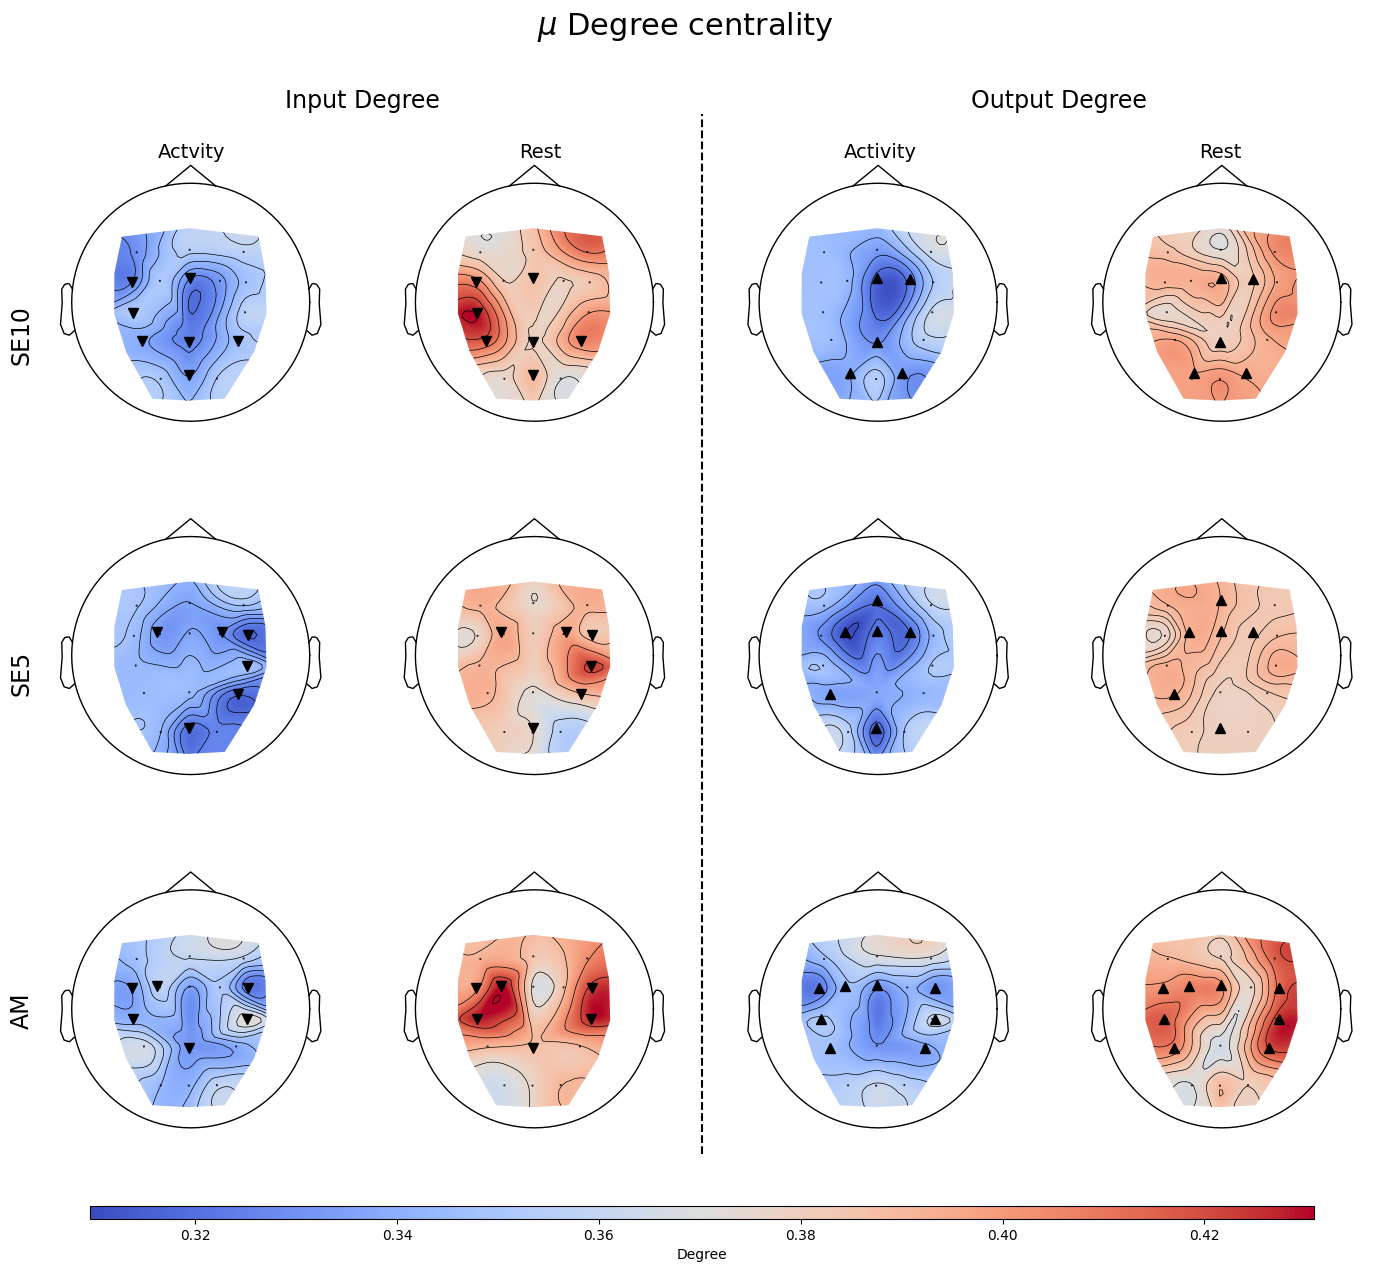

In [139]:

fig, axes = plt.subplots(3, 4, figsize=(17, 13))

y_min = 0.21

plt.suptitle(fr'$\{band}$ Degree centrality', fontsize=22)

plt.text(0.31, 0.91, 'Input Degree', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17)
plt.text(0.72, 0.91, 'Output Degree', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17)

plt.text(0.21, 0.87, 'Actvity', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=14)
plt.text(0.415, 0.87, 'Rest', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=14)

plt.text(0.615, 0.87, 'Activity', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=14)
plt.text(0.815, 0.87, 'Rest', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=14)

plt.text(0.11, y_min + 0.26*2, 'SE10', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')
plt.text(0.11, y_min + 0.26, 'SE5', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')
plt.text(0.11, y_min, 'AM', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')

plt.axis('off')
line = plt.Line2D([0.51, 0.51], [0.1, 0.90], transform=fig.transFigure, color='black', linestyle='--')
fig.add_artist(line)


cmap = "coolwarm"
#cmap = "Reds"
#cmap = "RdYlBu"
#cmap = "jet"
#cmap = "seismic"

electrode_color_act = "black"
electrode_color_rep = "black"

electrode_size = 7
electrode_style_input = "v"
electrode_style_output = "^"

im, _ = mne.viz.plot_topomap(act_10in, info, cmap=cmap, axes=axes[0, 0], vlim=(in_mini, in_maxi), show=False, extrapolate='local')
for electrode in significant_in_channels10:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[0, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(rep_10in, info, cmap=cmap, axes=axes[0, 1], vlim=(in_mini, in_maxi), show=False, extrapolate='local')
for electrode in significant_in_channels10:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[0, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_rep, markersize=electrode_size, label=electrode)

im_out, _ =mne.viz.plot_topomap(act_10out, info, cmap=cmap, axes=axes[0, 2], vlim=(out_mini, out_maxi), show=False, extrapolate='local')
for electrode in significant_out_channels10:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[0, 2].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_output, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(rep_10out, info, cmap=cmap, axes=axes[0, 3], vlim=(out_mini, out_maxi), show=False, extrapolate='local')
for electrode in significant_out_channels10:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[0, 3].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_output, color=electrode_color_rep, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(act_5in, info, cmap=cmap, axes=axes[1, 0], vlim=(in_mini, in_maxi), show=False, extrapolate='local')
for electrode in significant_in_channels5:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[1, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)

mne.viz.plot_topomap(rep_5in, info, cmap=cmap, axes=axes[1, 1], vlim=(in_mini, in_maxi), show=False, extrapolate='local')
for electrode in significant_in_channels5:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[1, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_rep, markersize=electrode_size, label=electrode)

mne.viz.plot_topomap(act_5out, info, cmap=cmap, axes=axes[1, 2], vlim=(out_mini, out_maxi), show=False, extrapolate='local')
for electrode in significant_out_channels5:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[1, 2].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_output, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(rep_5out, info, cmap=cmap, axes=axes[1, 3], vlim=(out_mini, out_maxi), show=False, extrapolate='local')
for electrode in significant_out_channels5:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[1, 3].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_output, color=electrode_color_rep, markersize=electrode_size, label=electrode)

mne.viz.plot_topomap(act_0in, info, cmap=cmap, axes=axes[2, 0], vlim=(in_mini, in_maxi), show=False, extrapolate='local')
for electrode in significant_in_channels0:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[2, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(rep_0in, info, cmap=cmap, axes=axes[2, 1], vlim=(in_mini, in_maxi), show=False, extrapolate='local')
for electrode in significant_in_channels0:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[2, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_rep, markersize=electrode_size, label=electrode)

mne.viz.plot_topomap(act_0out, info, cmap=cmap, axes=axes[2, 2], vlim=(out_mini, out_maxi), show=False, extrapolate='local')
for electrode in significant_out_channels0:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[2, 2].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_output, color=electrode_color_act, markersize=electrode_size, label=electrode)

mne.viz.plot_topomap(rep_0out, info, cmap=cmap, axes=axes[2, 3], vlim=(out_mini, out_maxi), show=False, extrapolate='local')
for electrode in significant_out_channels0:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[2, 3].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_output, color=electrode_color_rep, markersize=electrode_size, label=electrode)

cbar_ax = fig.add_axes([0.15, 0.05, 0.72, 0.01])  # [left, bottom, width, height]

fig.colorbar(im, cax=cbar_ax, label='Degree', orientation='horizontal')


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [140]:
act_betweenness_centrality_10.shape

(169, 16)

# Bewtweeness Centrality Visualization

In [141]:
act_bet10 = np.mean(act_betweenness_centrality_10, axis=0)
rep_bet10 = np.mean(rep_betweenness_centrality_10, axis=0)

act_bet5 = np.mean(act_betweenness_centrality_5, axis=0)
rep_bet5 = np.mean(rep_betweenness_centrality_5, axis=0)

act_bet0 = np.mean(act_betweenness_centrality_0, axis=0)
rep_bet0 = np.mean(rep_betweenness_centrality_0, axis=0)


In [142]:
mini = np.min([act_bet10, act_bet5, act_bet0, rep_bet10, rep_bet5, rep_bet0])
maxi = np.max([act_bet10, act_bet5, act_bet0, rep_bet10, rep_bet5, rep_bet0])

mini = np.min([act_bet10, act_bet5, act_bet0])
maxi = np.max([act_bet10, act_bet5, act_bet0])


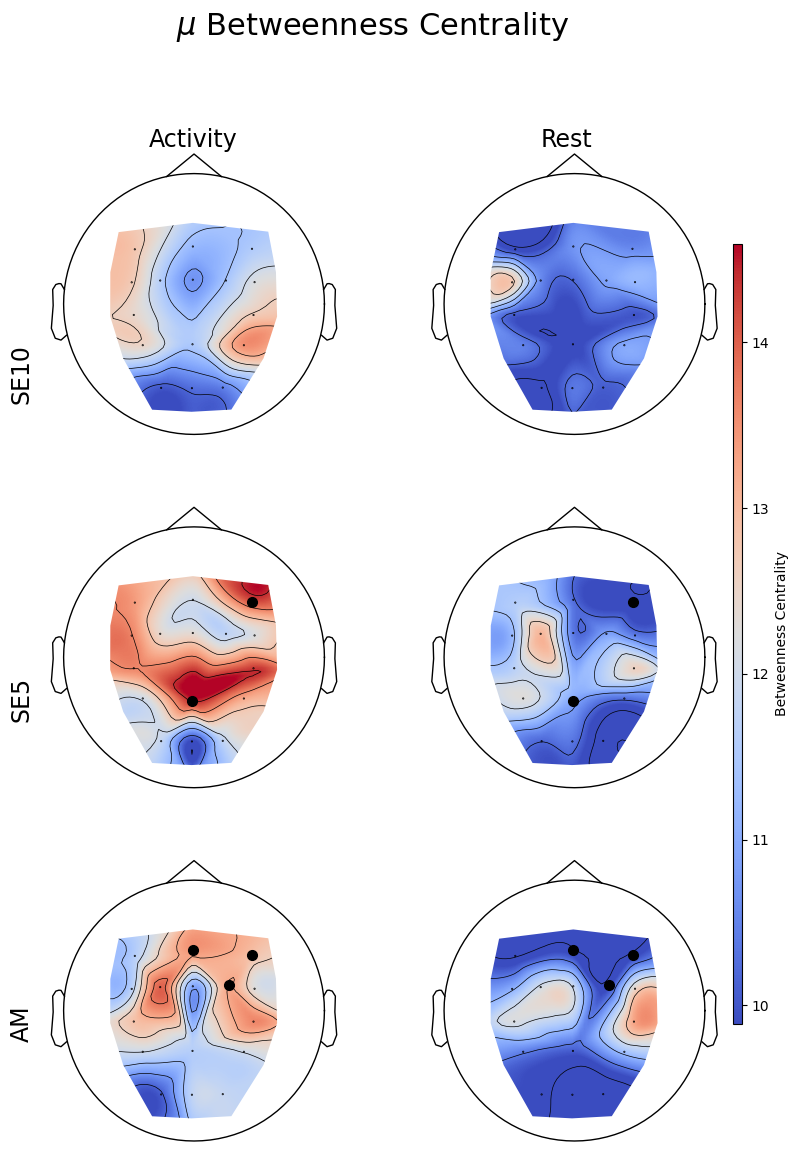

In [143]:
# Crear la figura
## top = 840
## right = 890

fig, axes = plt.subplots(3, 2, figsize=(9, 13))

y_min = 0.2

plt.suptitle(fr'$\{band}$ Betweenness Centrality', fontsize=22)

plt.text(0.30, 0.88, 'Activity', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17)
plt.text(0.715, 0.88, 'Rest', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17)

plt.text(0.11, y_min + 0.25*2, 'SE10', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')
plt.text(0.11, y_min + 0.25, 'SE5', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')
plt.text(0.11, y_min, 'AM', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')
plt.axis('off')

cmap = "coolwarm"
#cmap = "seismic"
#cmap = "jet"
electrode_style_input = "o"
electrode_style_output = "o"

im, _ = mne.viz.plot_topomap(act_bet10, info, cmap=cmap, axes=axes[0, 0], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels10:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[0, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(rep_bet10, info, cmap=cmap, axes=axes[0, 1], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels10:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[0, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(act_bet5, info, cmap=cmap, axes=axes[1, 0], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels5:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[1, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(rep_bet5, info, cmap=cmap, axes=axes[1, 1], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels5:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[1, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)



mne.viz.plot_topomap(act_bet0, info, cmap=cmap, axes=axes[2, 0], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels0:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[2, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)



mne.viz.plot_topomap(rep_bet0, info, cmap=cmap, axes=axes[2, 1], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels0:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[2, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)



cbar_ax = fig.add_axes([0.9, 0.20, 0.01, 0.60])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Betweenness Centrality', orientation='vertical')

plt.show()

# Clustering Coefficient Visualization

In [144]:
band = band

In [145]:
def get_clusteringcoeff(adj_matrix):
    """
    Calculate the clustering coefficient for each node in the adjacency matrix.

    Parameters:
    adj_matrix (numpy.ndarray): Adjacency matrix representing the graph.

    Returns:
    numpy.ndarray: Array of clustering coefficients for each node.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)
    
    # Calculate the clustering coefficient for each node
    clustering_coeffs = nx.clustering(G)
    
    # Convert the clustering coefficients to a numpy array
    clustering_coeffs_array = np.array(list(clustering_coeffs.values()))
    
    return clustering_coeffs_array

In [146]:
import numpy as np

def get_ntwk_clusteringcoeff(Cargas, band="mu", tipo="actividad", thresh=0, only_eeg=True, ch_names=None, same_windows=True):
    if ch_names is None:
        ch_names = np.array(['FC3', 'FCz', 'FC4', 'CP3', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP4', 'P3', 'Pz', 'P4', 'O1', 'Oz', 'O2'], dtype=object)
    
    clustering_coefficient_node_all = []
    max_win = []

    for carga in Cargas:
        if same_windows:
            len_windows_act = carga.get_network(band, band).array_mat_act.shape[0]
            len_windows_rep = carga.get_network(band, band).array_mat_rep.shape[0]
            len_windows = min(len_windows_act, len_windows_rep)

        if tipo == "actividad":
            if same_windows:
                matrices_actividad = carga.get_network(band, band).array_mat_act[:len_windows]
            else:
                matrices_actividad = carga.get_network(band, band).array_mat_act
            
            clustering_coefficient_node_all_each = []

            for test_mat in matrices_actividad:
                if only_eeg:
                    test_mat = test_mat[5:, 5:]

                temp_clustering = get_clusteringcoeff(test_mat)
                clustering_coefficient_node_all_each.append(temp_clustering)
         
        else:
            if same_windows:
                matrices_reposo = carga.get_network(band, band).array_mat_rep[:len_windows]
            else:
                matrices_reposo = carga.get_network(band, band).array_mat_rep
            
            clustering_coefficient_node_all_each = []

            for test_mat in matrices_reposo:
                if only_eeg:
                    test_mat = test_mat[5:, 5:]

                temp_clustering = get_clusteringcoeff(test_mat)
                clustering_coefficient_node_all_each.append(temp_clustering)
        
        clustering_coefficient_node_all_each = np.array(clustering_coefficient_node_all_each)
        max_win.append(clustering_coefficient_node_all_each.shape[0])
        if clustering_coefficient_node_all_each.shape[0] > 0:
            clustering_coefficient_node_all_temp_padded = np.zeros((6, clustering_coefficient_node_all_each.shape[1]))
            clustering_coefficient_node_all_temp_padded[:clustering_coefficient_node_all_each.shape[0], :] = clustering_coefficient_node_all_each
            clustering_coefficient_node_all.append(clustering_coefficient_node_all_temp_padded)
    
        
    clustering_coefficient_node_all = np.array(clustering_coefficient_node_all)
    max_win = np.array(max_win)

    return clustering_coefficient_node_all, max_win

In [147]:
arr_act_10cc, max_win = get_ntwk_clusteringcoeff(Carga_10, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
act_10CC = np.mean(desenvolver_ventanas(arr_act_10cc, max_win), axis=0)

arr_rep_10cc, max_win = get_ntwk_clusteringcoeff(Carga_10, band = band, tipo = "reposo", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
rep_10CC = np.mean(desenvolver_ventanas(arr_rep_10cc, max_win), axis=0)

arr_act_5cc, max_win = get_ntwk_clusteringcoeff(Carga_5, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
act_5CC = np.mean(desenvolver_ventanas(arr_act_5cc, max_win), axis=0)

arr_rep_5cc, max_win = get_ntwk_clusteringcoeff(Carga_5, band = band, tipo = "reposo", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
rep_5CC = np.mean(desenvolver_ventanas(arr_rep_5cc, max_win), axis=0)

arr_act_0cc, max_win = get_ntwk_clusteringcoeff(Carga_0, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
act_0CC = np.mean(desenvolver_ventanas(arr_act_0cc, max_win), axis=0)

arr_rep_0cc, max_win = get_ntwk_clusteringcoeff(Carga_0, band = band, tipo = "reposo", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
rep_0CC = np.mean(desenvolver_ventanas(arr_rep_0cc, max_win), axis=0)


In [148]:
def generate_df(Carga, banda, label_act = "actividad", label_rep = "reposo", ch_names = ch_names[5:]):
    arr_act_10cc, max_win = get_ntwk_clusteringcoeff(Carga, band = band, tipo = "actividad", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
    act_10CC = desenvolver_ventanas(arr_act_10cc, max_win)

    arr_rep_10cc, max_win = get_ntwk_clusteringcoeff(Carga, band = band, tipo = "reposo", thresh=thresh, only_eeg=True, ch_names=ch_names[5:])
    rep_10CC = desenvolver_ventanas(arr_rep_10cc, max_win)

    act_label = label_act
    rep_label = label_rep

    df_act = pd.DataFrame(act_10CC, columns=ch_names)
    df_act["label"] = act_label

    df_rep = pd.DataFrame(rep_10CC, columns=ch_names)
    df_rep["label"] = rep_label

    df = pd.concat([df_act, df_rep], axis=0)

    return df



In [149]:
df_10 = generate_df(Carga_10, band)
df_5 = generate_df(Carga_5, band)
df_0 = generate_df(Carga_0, band)


In [150]:
df_10

,FC3,FCz,FC4,CP3,C3,C1,Cz,C2,C4,CP4,P3,Pz,P4,O1,Oz,O2,label
0,0.535714,0.571429,0.422222,0.666667,0.535714,0.333333,0.700000,0.166667,0.400000,0.666667,0.333333,0.666667,0.464286,0.333333,0.166667,0.428571,actividad
1,1.000000,0.772727,0.666667,0.636364,0.733333,0.466667,0.781818,0.688889,0.772727,0.500000,0.678571,0.653846,0.757576,0.787879,0.888889,0.727273,actividad
2,0.400000,0.428571,0.333333,0.428571,0.400000,0.464286,0.476190,0.392857,0.666667,0.400000,0.535714,0.466667,1.000000,0.466667,0.700000,0.300000,actividad
3,0.200000,0.700000,0.428571,1.000000,0.500000,0.476190,0.500000,0.357143,0.466667,0.133333,0.333333,1.000000,0.000000,0.333333,0.133333,0.166667,actividad
4,0.872727,0.923077,0.923077,0.897436,0.861111,0.909091,0.884615,0.879121,1.000000,0.791209,0.884615,0.924242,0.878788,0.780952,0.923077,0.813187,actividad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,0.600000,0.821429,0.644444,0.555556,0.512821,0.571429,0.933333,0.428571,0.563636,0.666667,0.527778,0.545455,0.523810,0.611111,0.476190,0.611111,reposo
165,0.523810,0.533333,0.636364,0.654545,0.600000,0.700000,0.750000,0.672727,0.628205,0.777778,0.571429,0.733333,0.642857,0.712121,0.857143,0.727273,reposo
166,0.805556,0.583333,0.523810,0.644444,0.666667,0.581818,0.602564,0.644444,0.678571,0.641026,0.666667,0.642857,0.672727,0.622222,0.644444,0.644444,reposo
167,0.321429,0.428571,0.666667,0.400000,0.535714,0.333333,0.700000,0.500000,0.642857,0.500000,0.666667,0.333333,0.333333,0.333333,0.464286,0.400000,reposo


In [151]:
p_val = 0.01

significant_columns_10, p_values = get_significat_cols(df_10, test = "t_test", verbose=False, p_val=pval)
significant_columns_5, p_values = get_significat_cols(df_5, test = "t_test", verbose=False, p_val=pval)
significant_columns_0, p_values = get_significat_cols(df_0, test = "t_test", verbose=False, p_val=pval)

df10in_sig = df_10[significant_columns_10 + ["label"]]
df10in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df10in_sig.columns]

df5in_sig = df_5[significant_columns_5 + ["label"]]
df5in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df5in_sig.columns]

df0in_sig = df_0[significant_columns_0 + ["label"]]
df0in_sig.columns = [col.split('_')[0] if col != 'label' else col for col in df0in_sig.columns]


significant_bet_channels10 = df10in_sig.columns[:-1]
significant_bet_channels5 = df5in_sig.columns[:-1]
significant_bet_channels0 = df0in_sig.columns[:-1]

In [152]:
mini = np.min([act_10CC, act_5CC, act_0CC, rep_10CC, rep_5CC, rep_0CC])
maxi = np.max([act_10CC, act_5CC, act_0CC, rep_10CC, rep_5CC, rep_0CC])

#mini = np.min([act_10CC, act_5CC, act_0CC])
#maxi = np.max([act_10CC, act_5CC, act_0CC])



In [153]:
mini

0.4944506840956545

In [154]:
maxi

0.6407576867576865

C:\Users\fercy\AppData\Local\Temp\ipykernel_20876\1522046365.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.84, 0.11, 0.085, 0.9], h_pad=0.185, w_pad=0.07)
C:\Users\fercy\AppData\Local\Temp\ipykernel_20876\1522046365.py:87: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[0.84, 0.11, 0.085, 0.9], h_pad=0.185, w_pad=0.07)


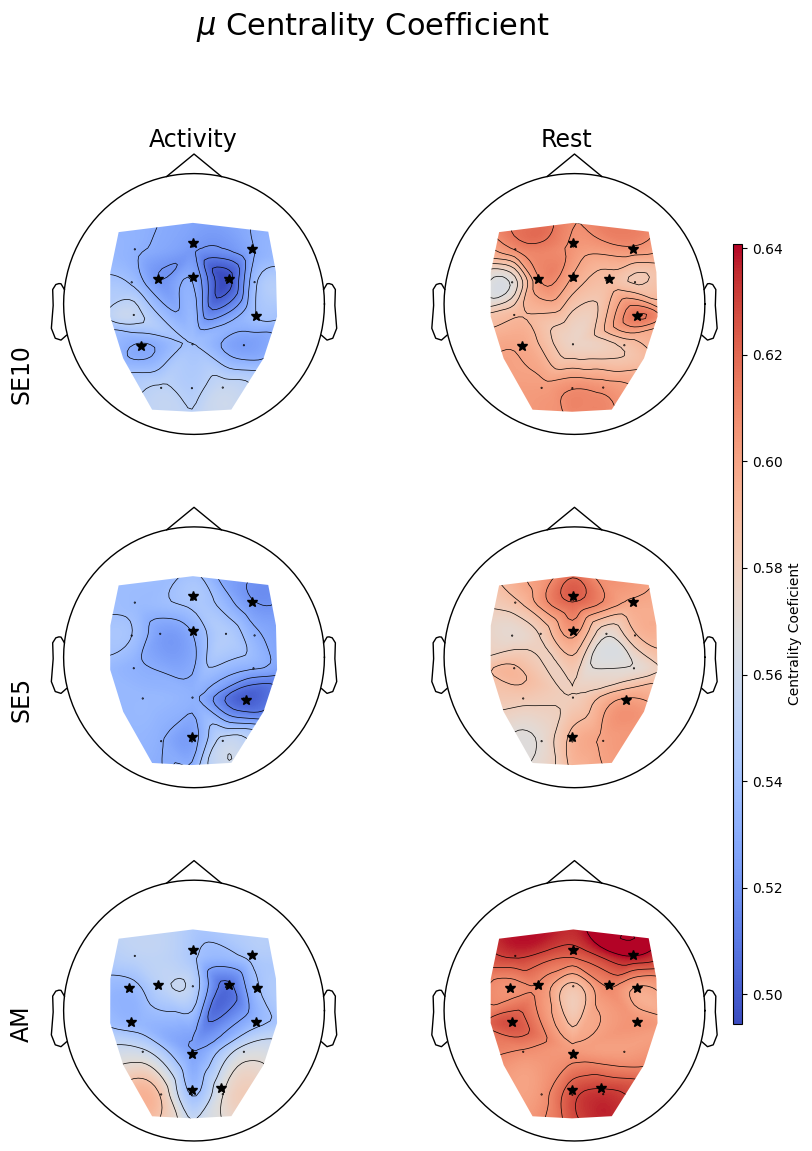

In [155]:
# Crear la figura
fig, axes = plt.subplots(3, 2, figsize=(9, 13))


y_min = 0.2

plt.suptitle(fr'$\{band}$ Centrality Coefficient ', fontsize=22)

plt.text(0.30, 0.88, 'Activity', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17)
plt.text(0.715, 0.88, 'Rest', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17)

plt.text(0.11, y_min + 0.25*2, 'SE10', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')
plt.text(0.11, y_min + 0.25, 'SE5', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')
plt.text(0.11, y_min, 'AM', ha='center', va='center', transform=plt.gcf().transFigure, fontsize=17, rotation='vertical')
plt.axis('off')

cmap = "coolwarm"
#cmap = "seismic"
#cmap = "jet"
electrode_style_input = '*'

im, _ = mne.viz.plot_topomap(act_10CC, info, cmap=cmap, axes=axes[0, 0], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels10:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[0, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(rep_10CC, info, cmap=cmap, axes=axes[0, 1], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels10:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[0, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(act_5CC, info, cmap=cmap, axes=axes[1, 0], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels5:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[1, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


mne.viz.plot_topomap(rep_5CC, info, cmap=cmap, axes=axes[1, 1], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels5:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[1, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)



mne.viz.plot_topomap(act_0CC, info, cmap=cmap, axes=axes[2, 0], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels0:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[2, 0].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)



mne.viz.plot_topomap(rep_0CC, info, cmap=cmap, axes=axes[2, 1], vlim=(mini, maxi), show=False, extrapolate='local')
for electrode in significant_bet_channels0:
    if electrode not in info.ch_names:
        continue
    idx = mne.pick_channels(info.ch_names, include=[electrode])  
    if idx:  
        pos = info['chs'][idx[0]]['loc'][:2]  
        axes[2, 1].plot(pos[0] * 0.7, pos[1] * 0.7, electrode_style_input, color=electrode_color_act, markersize=electrode_size, label=electrode)


cbar_ax = fig.add_axes([0.9, 0.20, 0.01, 0.60])  # [left, bottom, width, height]

fig.colorbar(im, cax=cbar_ax, label='Centrality Coeficient', orientation='vertical')
fig.tight_layout(rect=[0.84, 0.11, 0.085, 0.9], h_pad=0.185, w_pad=0.07)


plt.show()

# Global metrics

In [156]:
means_10in = np.mean(arr_act_10in, axis=1).flatten()
means_5in = np.mean(arr_act_5in, axis=1).flatten()
means_0in = np.mean(arr_act_0in, axis=1).flatten()
global_input_deg = np.concatenate((means_10in, means_5in, means_0in))

means_10out = np.mean(arr_act_10out, axis=1).flatten()
means_5out = np.mean(arr_act_5out, axis=1).flatten()
means_0out = np.mean(arr_act_0out, axis=1).flatten()
global_output_deg = np.concatenate((means_10out, means_5out, means_0out))

bet_10cc = np.mean(act_betweenness_centrality_10, axis=1).flatten()
bet_5cc = np.mean(act_betweenness_centrality_5, axis=1).flatten()
bet_0cc = np.mean(act_betweenness_centrality_0, axis=1).flatten()
global_bet = np.concatenate((bet_10cc, bet_5cc, bet_0cc))

means_10cc = np.mean(desenvolver_ventanas(arr_act_10cc, max_win), 1).flatten()
means_5cc = np.mean(desenvolver_ventanas(arr_act_5cc, max_win), 1).flatten()
means_0cc = np.mean(desenvolver_ventanas(arr_act_0cc, max_win), 1).flatten()
global_cc = np.concatenate((means_10cc[:len(bet_10cc)], means_5cc[:len(bet_5cc)], means_0cc[:len(bet_0cc)]))

label = np.concatenate((np.repeat('SE10', len(means_10in)), np.repeat('SE5', len(means_5in)), np.repeat('AM', len(means_0in))))

data = pd.DataFrame({
    "Input Degree": global_input_deg,
    "Output Degree": global_output_deg,
    "Clustering Coefficient": global_cc,
    "Betweenness Centrality": global_bet / 16,
    "label": label
})



In [157]:
means_10in = np.mean(arr_rep_10in, axis=1).flatten()
means_5in = np.mean(arr_rep_5in, axis=1).flatten()
means_0in = np.mean(arr_rep_0in, axis=1).flatten()
global_input_deg = np.concatenate((means_10in, means_5in, means_0in))

means_10out = np.mean(arr_rep_10out, axis=1).flatten()
means_5out = np.mean(arr_rep_5out, axis=1).flatten()
means_0out = np.mean(arr_rep_0out, axis=1).flatten()
global_output_deg = np.concatenate((means_10out, means_5out, means_0out))

bet_10cc = np.mean(rep_betweenness_centrality_10, axis=1).flatten()
bet_5cc = np.mean(rep_betweenness_centrality_5, axis=1).flatten()
bet_0cc = np.mean(rep_betweenness_centrality_0, axis=1).flatten()
global_bet = np.concatenate((bet_10cc, bet_5cc, bet_0cc))

means_10cc = np.mean(desenvolver_ventanas(arr_rep_10cc, max_win), 1).flatten()
means_5cc = np.mean(desenvolver_ventanas(arr_rep_5cc, max_win), 1).flatten()
means_0cc = np.mean(desenvolver_ventanas(arr_rep_0cc, max_win), 1).flatten()
global_cc = np.concatenate((means_10cc[:len(bet_10cc)], means_5cc[:len(bet_5cc)], means_0cc[:len(bet_0cc)]))

label = np.concatenate((np.repeat('SE10', len(means_10in)), np.repeat('SE5', len(means_5in)), np.repeat('AM', len(means_0in))))

data_rep = pd.DataFrame({
    "Input Degree": global_input_deg,
    "Output Degree": global_output_deg,
    "Clustering Coefficient": global_cc,
    "Betweenness Centrality": global_bet / 16,
    "label": label
})


In [158]:
%matplotlib inline

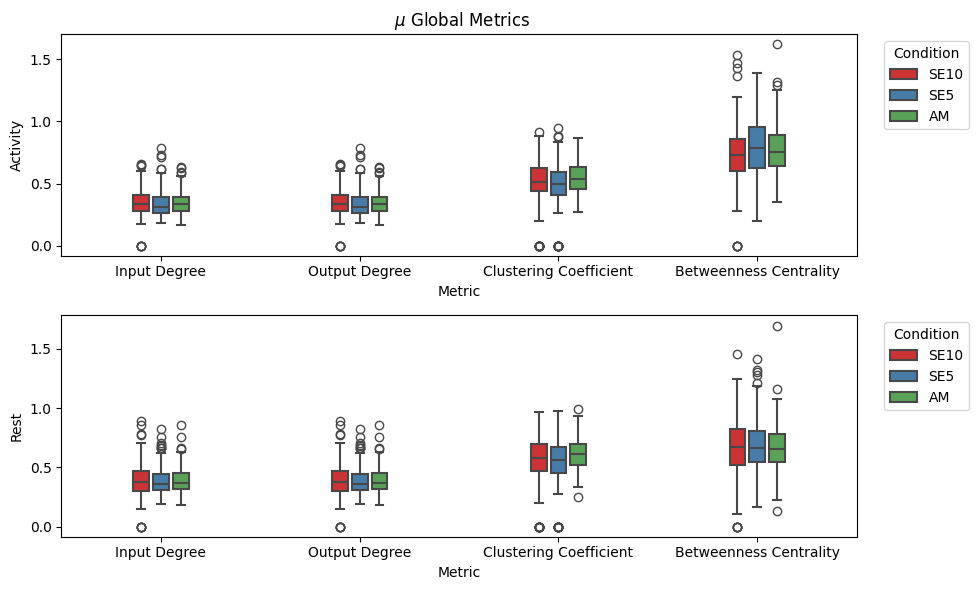

In [159]:
# Melt the DataFrame for seaborn
data_melted = data.melt(id_vars=['label'], value_vars=["Input Degree", "Output Degree", "Clustering Coefficient", "Betweenness Centrality"], var_name='Metric', value_name='Value')
data_melted_rep = data_rep.melt(id_vars=['label'], value_vars=["Input Degree", "Output Degree", "Clustering Coefficient", "Betweenness Centrality"], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
sns.boxplot(data=data_melted, x='Metric', y='Value', hue='label', width=0.3, palette='Set1', linewidth=1.5, showmeans=False, gap = 0.2, log_scale=False)

plt.ylabel(rf'Activity')
plt.title(rf' $\{band}$ Global Metrics')
plt.legend(title='Condition', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

plt.subplot(2, 1, 2)
sns.boxplot(data=data_melted_rep, x='Metric', y='Value', hue='label', width=0.3, palette='Set1', linewidth=1.5, showmeans=False, gap = 0.2, log_scale=False)

plt.ylabel(rf'Rest')
plt.legend(title='Condition', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

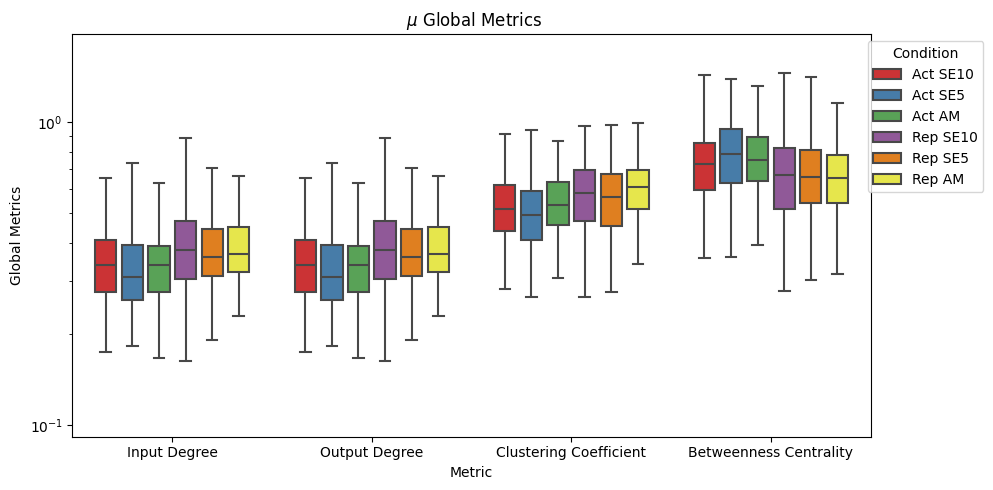

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

means_10in = np.mean(arr_act_10in, axis=1).flatten()
means_5in = np.mean(arr_act_5in, axis=1).flatten()
means_0in = np.mean(arr_act_0in, axis=1).flatten()
global_input_deg = np.concatenate((means_10in, means_5in, means_0in))

means_10out = np.mean(arr_act_10out, axis=1).flatten()
means_5out = np.mean(arr_act_5out, axis=1).flatten()
means_0out = np.mean(arr_act_0out, axis=1).flatten()
global_output_deg = np.concatenate((means_10out, means_5out, means_0out))

bet_10cc = np.mean(act_betweenness_centrality_10, axis=1).flatten()
bet_5cc = np.mean(act_betweenness_centrality_5, axis=1).flatten()
bet_0cc = np.mean(act_betweenness_centrality_0, axis=1).flatten()
global_bet = np.concatenate((bet_10cc, bet_5cc, bet_0cc))

means_10cc = np.mean(desenvolver_ventanas(arr_act_10cc, max_win), 1).flatten()
means_5cc = np.mean(desenvolver_ventanas(arr_act_5cc, max_win), 1).flatten()
means_0cc = np.mean(desenvolver_ventanas(arr_act_0cc, max_win), 1).flatten()
global_cc = np.concatenate((means_10cc[:len(bet_10cc)], means_5cc[:len(bet_5cc)], means_0cc[:len(bet_0cc)]))

label = np.concatenate((np.repeat('Act SE10', len(means_10in)), np.repeat('Act SE5', len(means_5in)), np.repeat('Act AM', len(means_0in))))

data1 = pd.DataFrame({
    "Input Degree": global_input_deg,
    "Output Degree": global_output_deg,
    "Clustering Coefficient": global_cc,
    "Betweenness Centrality": global_bet / 16,
    "label": label,
    
})


means_10in_2 = np.mean(arr_rep_10in, axis=1).flatten()
means_5in_2 = np.mean(arr_rep_5in, axis=1).flatten()
means_0in_2 = np.mean(arr_rep_0in, axis=1).flatten()
global_input_deg_2 = np.concatenate((means_10in_2, means_5in_2, means_0in_2))

means_10out_2 = np.mean(arr_rep_10out, axis=1).flatten()
means_5out_2 = np.mean(arr_rep_5out, axis=1).flatten()
means_0out_2 = np.mean(arr_rep_0out, axis=1).flatten()
global_output_deg_2 = np.concatenate((means_10out_2, means_5out_2, means_0out_2))

bet_10cc_2 = np.mean(rep_betweenness_centrality_10, axis=1).flatten()
bet_5cc_2 = np.mean(rep_betweenness_centrality_5, axis=1).flatten()
bet_0cc_2 = np.mean(rep_betweenness_centrality_0, axis=1).flatten()
global_bet_2 = np.concatenate((bet_10cc_2, bet_5cc_2, bet_0cc_2))

means_10cc_2 = np.mean(desenvolver_ventanas(arr_rep_10cc, max_win), 1).flatten()
means_5cc_2 = np.mean(desenvolver_ventanas(arr_rep_5cc, max_win), 1).flatten()
means_0cc_2 = np.mean(desenvolver_ventanas(arr_rep_0cc, max_win), 1).flatten()
global_cc_2 = np.concatenate((means_10cc_2[:len(bet_10cc_2)], means_5cc_2[:len(bet_5cc_2)], means_0cc_2[:len(bet_0cc_2)]))

label_2 = np.concatenate((np.repeat('Rep SE10', len(means_10in_2)), np.repeat('Rep SE5', len(means_5in_2)), np.repeat('Rep AM', len(means_0in_2))))

data2 = pd.DataFrame({
    "Input Degree": global_input_deg_2,
    "Output Degree": global_output_deg_2,
    "Clustering Coefficient": global_cc_2,
    "Betweenness Centrality": global_bet_2 / 16,
    "label": label_2,
    
})


combined_data = pd.concat([data1, data2])
data_melted = combined_data.melt(id_vars=['label'], value_vars=["Input Degree", "Output Degree", "Clustering Coefficient", "Betweenness Centrality"], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 5))
sns.boxplot(data=data_melted, x='Metric', y='Value', hue='label', palette='Set1', linewidth=1.5, showmeans=False, gap = 0.2, log_scale=True, fliersize=0)

plt.ylabel('Global Metrics')
plt.xlabel('Metric')
plt.title(rf' $\{band}$ Global Metrics')
plt.legend(title='Condition', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()